In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

# TensorFlow warning suppression
import os
import logging
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

params = {'font.size': 18,
          'axes.linewidth':1}
plt.rcParams.update(params)

## Importing Experimental Data (AME2016)

In [2]:
# Keeping relevant columns from AME2016 dataset 
data = pd.read_csv('EXPERIMENT_AME2016.dat', sep=r'\s+', usecols=['A', 'N', 'Z', 'E', 'E/A'])
data = data.loc[data['Z'] >= 20]
data.head()

,A,N,Z,E,E/A
350,34,14,20,-244.917409,-7.203453
351,35,15,20,-262.026409,-7.486469
352,36,16,20,-281.353053,-7.815363
353,37,17,20,-296.109281,-8.002954
354,38,18,20,-313.103043,-8.239554


## Finding SEMF parameters by least squares

In [3]:
# First add coefficients of each term in the formula to the dataset 
data['semf_surface'] = -data['A']**(2/3)
data['semf_coulomb'] = -data['Z']*(data['Z'] -1)/data['A']**(1/3)
data['semf_asymmetry'] = -(data['A'] - 2*data['Z'])**2/data['A']
data['semf_pairing'] = data['A']*0 


# Odd-even delta for pairing term
for i in data.index:
    mass_num = data.loc[i, 'A']
    if mass_num % 2 == 0:
        if data.loc[i, 'Z'] % 2 == 0:
            data.loc[i, 'semf_pairing'] = mass_num**(-0.5)
        elif data.loc[i, 'Z'] % 2 == 1: 
            data.loc[i, 'semf_pairing'] = -mass_num**(-0.5)

data.head()

,A,N,Z,E,E/A,semf_surface,semf_coulomb,semf_asymmetry,semf_pairing
350,34,14,20,-244.917409,-7.203453,-10.495085,-117.298005,-1.058824,0.171499
351,35,15,20,-262.026409,-7.486469,-10.699875,-116.170069,-0.714286,0.000000
352,36,16,20,-281.353053,-7.815363,-10.902724,-115.084304,-0.444444,0.166667
353,37,17,20,-296.109281,-8.002954,-11.103702,-114.038025,-0.243243,0.000000
354,38,18,20,-313.103043,-8.239554,-11.302879,-113.028786,-0.105263,0.162221


In [4]:
# Convert into coefficient matrix 
coeff = np.asarray([data['A'], data['semf_surface'], data['semf_coulomb'],
    data['semf_asymmetry'], data['semf_pairing']])
# Transpose into columns
coeff = coeff.T
y = data['E']
# Least squares regression to find parameters 
params = np.linalg.lstsq(coeff, y, rcond=None)[0]
# Need parameters as column vector for next step
params = params[:, np.newaxis]
print(params)

[[-15.56054437]
 [-17.20918287]
 [ -0.708507  ]
 [-22.97878903]
 [-12.09663019]]


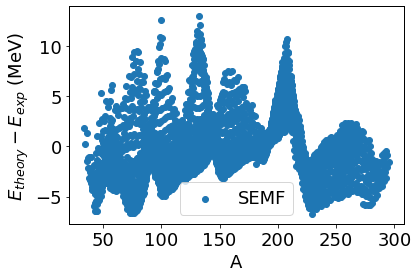

In [19]:
# Add SEMF predictions to dataset, plot comparison 
#data['semf_E/A'] = np.matmul(coeff, params)/np.array(data['A'], ndmin = 2).T
data['semf_E'] = np.matmul(coeff, params)#/np.array(data['A'], ndmin = 2).T
# Plot difference between SEMF predictions and experimental values 
plt.scatter(data['A'], (data['semf_E'] - data['E']), label='SEMF')
# Formula is more accurate for Z > 20, only plotting those
#plt.xlim(30, 300)
#plt.ylim(-0.16, 0.16)
plt.xlabel('A')
plt.ylabel('$E_{theory} - E_{exp}$ (MeV)')
plt.legend()
plt.show()

## Creating Neural Network

In [7]:
# Next, we design our model architecture to be optimized. Going with two hidden layers.   

def dnn_model(df, features, target, hyparms):
    x_features = df[features]
    y_target = df[target]
    batch_size = 64
    # Splitting into training/testing sets 
    x_train, x_test, y_train, y_test = train_test_split(x_features,y_target,train_size=0.8)
    # Creating normalizing object
    normalizer = tf.keras.layers.Normalization(axis=-1)
    # Normalizing inputs 
    normalizer.adapt(np.array(x_train))
    # Specifying model architecture 
    DNN_model = keras.Sequential([
      normalizer,
      layers.Dropout(hyparms[3]),
      layers.Dense(hyparms[1], activation='relu'),
      layers.Dropout(hyparms[3]),
      layers.Dense(hyparms[2], activation='relu'),
      layers.Dropout(hyparms[3]),
      # Regression problem requires only one linear output unit
      layers.Dense(1)])
    stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    # Loss function for regression, using Adam optimizer
    DNN_model.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanAbsoluteError())
    # Training model 
    history=DNN_model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=hyparms[0],
        callbacks=[stopping],
        verbose=0,
        validation_split=0.2)
    # Performance metrics during training 
    val_loss_per_epoch = history.history['val_loss']
    # After training, predicting target from features 
    y_prediction = DNN_model.predict(x_features)
    return y_prediction, val_loss_per_epoch

## Refining Architecture through Hyperparameter Optimization 

In [8]:
features = ['A', 'semf_surface', 'semf_coulomb', 'semf_asymmetry', 'semf_pairing']

# Creating function that trial runs the neural network for hyperparameter optimization
def dnn_evaluate(hyparms):
    n_nodes1 = int(hyparms['n_nodes1'])
    n_nodes2 = int(hyparms['n_nodes2'])
    frac_dropout = float(hyparms['frac_dropout'])
    # Optimization will seek to maximize validation score 
    model_score = dnn_model(data, features, 'E', [30, n_nodes1, n_nodes2, frac_dropout])[1][-1]
    return model_score #Maximize R^2_val = Minimize (-R^2_val)

In [9]:
# Defining hyperparameter space to be explored by optimization

space = {
    'frac_dropout': hp.uniform('frac_dropout', 0., 0.5),
    'n_nodes1': hp.quniform('n_nodes1', 40,300,20),
    'n_nodes2': hp.quniform('n_nodes2', 40,300,20),
}

# Results object
trials = Trials()

In [10]:
# Optimizing
besthyparms = fmin(dnn_evaluate, space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print results 
print("Val_loss",trials.best_trial['result']['loss'])
print(besthyparms)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

100%|██████████| 30/30 [02:51<00:00,  5.71s/trial, best loss: 9.205713272094727] 
Val_loss 9.205713272094727
{'act_func': 0, 'frac_dropout': 0.00041207114283949866, 'n_nodes1': 120.0, 'n_nodes2': 100.0}


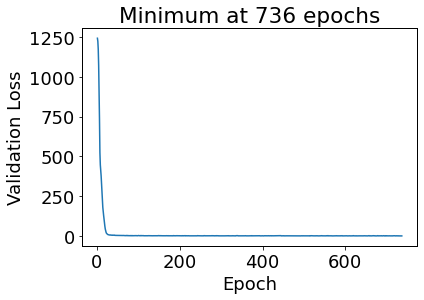

In [11]:
# Recording the best parameters from the optimization
frac_dropout = besthyparms['frac_dropout']
n_nodes1, n_nodes2 = besthyparms['n_nodes1'], besthyparms['n_nodes2']


n_epochs = 1000
losses = dnn_model(data, features, 'E', [n_epochs, n_nodes1, n_nodes2, frac_dropout])[1]
best_epoch = losses.index(min(losses)) + 1

plt.plot(np.arange(1, best_epoch+1), losses[:best_epoch])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
#plt.ylim(0, 0.05)
plt.title('Minimum at %3d epochs' % best_epoch)
plt.show()

In [12]:
# Reinstantiating the neural network with the best number of epochs
data['dnn_E'] = dnn_model(data, features, 'E', [best_epoch, n_nodes1, n_nodes2, frac_dropout])[0]

SEMF mean-squared error = 1.001294e+01, DNN mean-squared error = 3.687065e+00


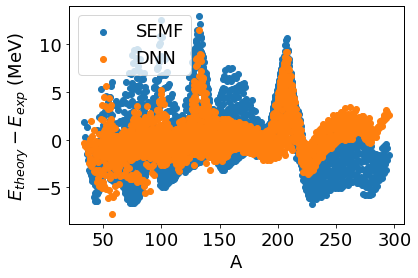

In [20]:
# Comparing error in mass predictions for both SEMF and neural network
SEMF_err = data['semf_E'] - data['E']
SEMF_mse = np.sum(SEMF_err**2)/len(data.index)
DNN_err = data['dnn_E'] - data['E']
DNN_mse = np.sum(DNN_err**2)/len(data.index)
print('SEMF mean-squared error = %5e, DNN mean-squared error = %5e' % (SEMF_mse, DNN_mse))

plt.scatter(data['A'], SEMF_err, label='SEMF')
plt.scatter(data['A'], DNN_err, label='DNN')
plt.xlabel('A')
plt.ylabel('$E_{theory} - E_{exp}$ (MeV)')
plt.legend()
plt.show()